# [Lecture 14 Correlated Features](https://www.youtube.com/watch?v=Es44-Bp1aKo&t)

In [1]:
%run init_notebook.py

Module aliases imported by init_notebook.py:
--------------------------------------------
import numpy as np

import pandas as pd

import statsmodels.formula.api as smf

import pymc as pm

import xarray as xr

import arviz as az

import utils as utils

from scipy import stats as stats

from matplotlib import pyplot as plt

Watermark:
----------
Last updated: 2023-09-08T11:24:09.888431-07:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.14.0

Compiler    : Clang 15.0.7 
OS          : Darwin
Release     : 22.2.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit

arviz      : 0.16.1
scipy      : 1.11.2
matplotlib : 3.7.1
pymc       : 5.7.2
statsmodels: 0.14.0
xarray     : 2023.8.0
numpy      : 1.25.2
pandas     : 2.0.3



# Revisiting Bangladesh Fertility

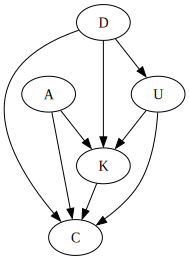

In [2]:
utils.draw_causal_graph(
    edge_list=[
        ("A", "C"),
        ("K", "C"),
        ("U", "C"),
        ("D", "C"),
        ("D", "U"),
        ("U", "K"),
        ("A", "K"),
        ("D", "K")
    ]
)

- **Estimand 1**: Contraceptive use $C$ in each District $D$
- **Estimand 2**: Effect of "urbanity" $U$
- **Estimand 3**: Effect of # of kids $K$ and age $A$

### Districts are _CLUSTERS_

#### Rural / Urban breakdown
Below we show the contraceptive use for rural (only including a district-level intercept $\alpha_{D[i]}$) vs urban (including an additional intercept $\beta_{D[i]}$ for urban districts) groups. These plow was generated in [Lecture 13 - Multilevel Adventures](<Lecture 13 - Multilevel Adventures.ipynb>).

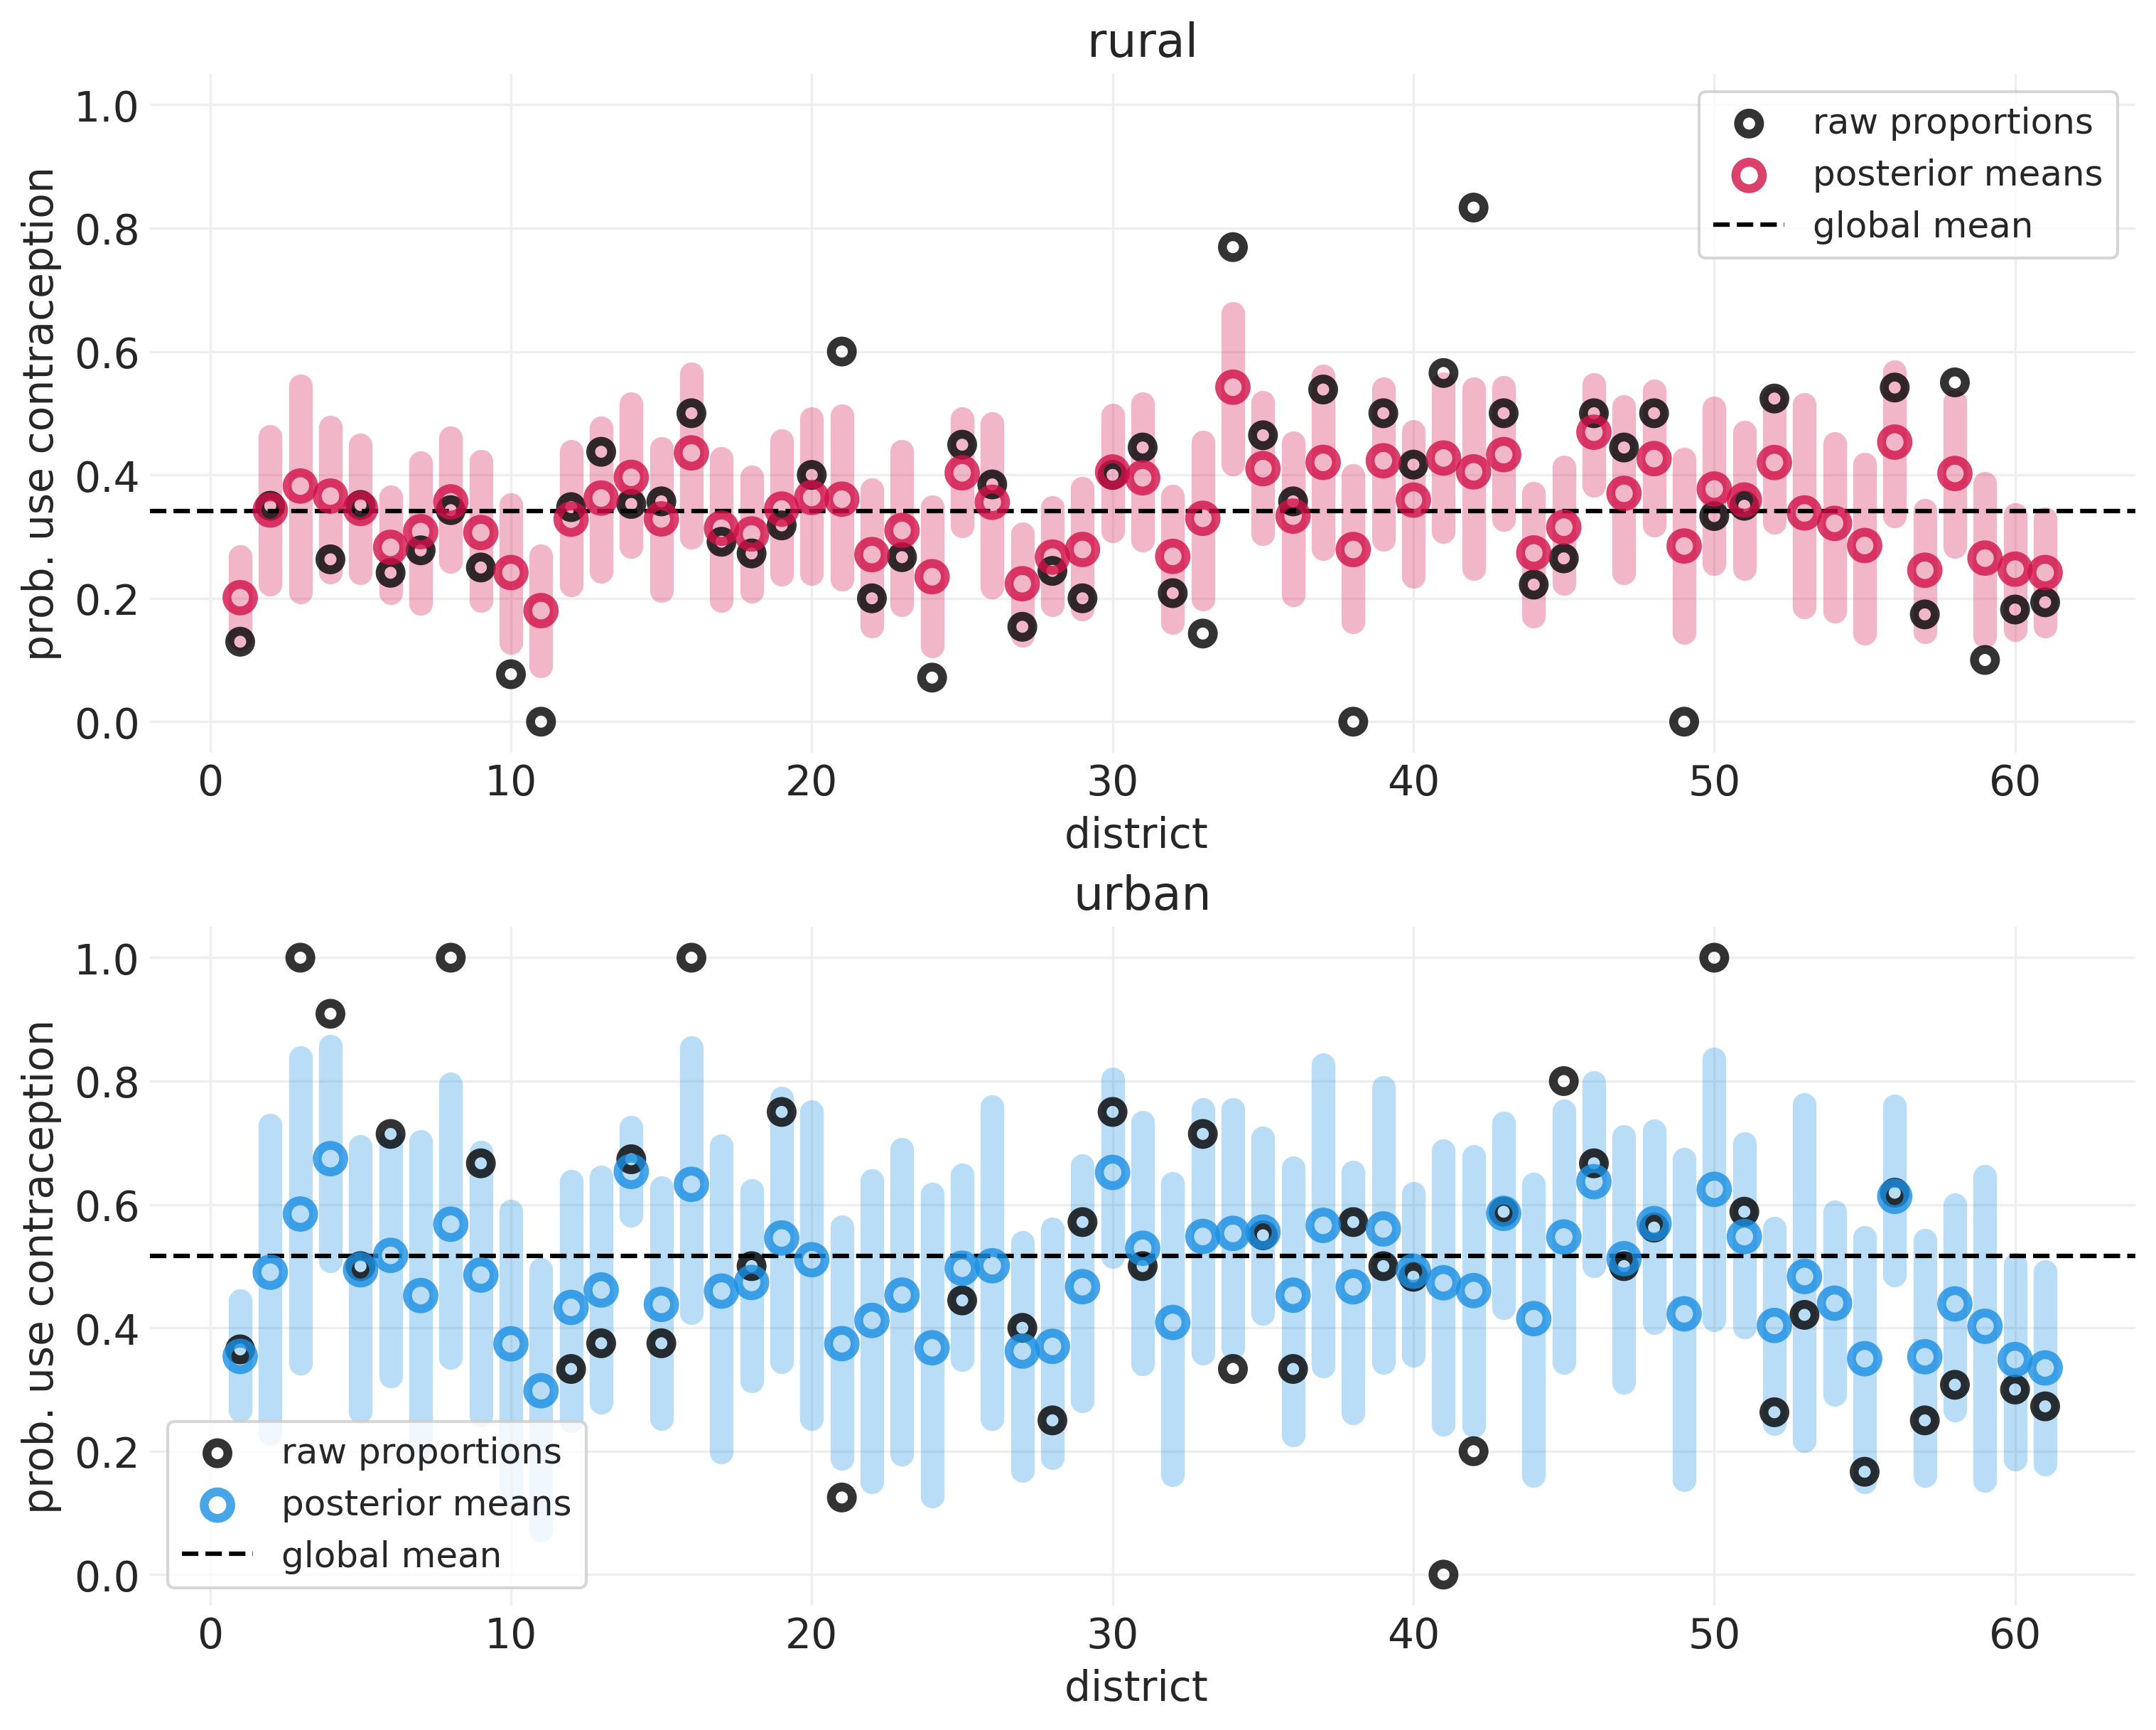

In [3]:
utils.display_image("fertility_posterior_means_rural_urban.png", width=1000)

The plot shows:

- Rural populations are, on average are less likely to use contraception than urban areas
  - the dashed line in the top plot is lower than that in the lower plot
- There are fewer urban samples, so there is a larger range of uncertaint for urban areas
  - the error blue bars associated with urban popluations are larger than for rural areas, where there were more polls sampled.

### Urbanism is a _Correlated Feature_

Below we plot the probability of contraceptive use for urban $p(C | U=1)$ vs rural $p(C|U=0)$ areas. These plow was generated in [Lecture 13 - Multilevel Adventures](<Lecture 13 - Multilevel Adventures.ipynb>).

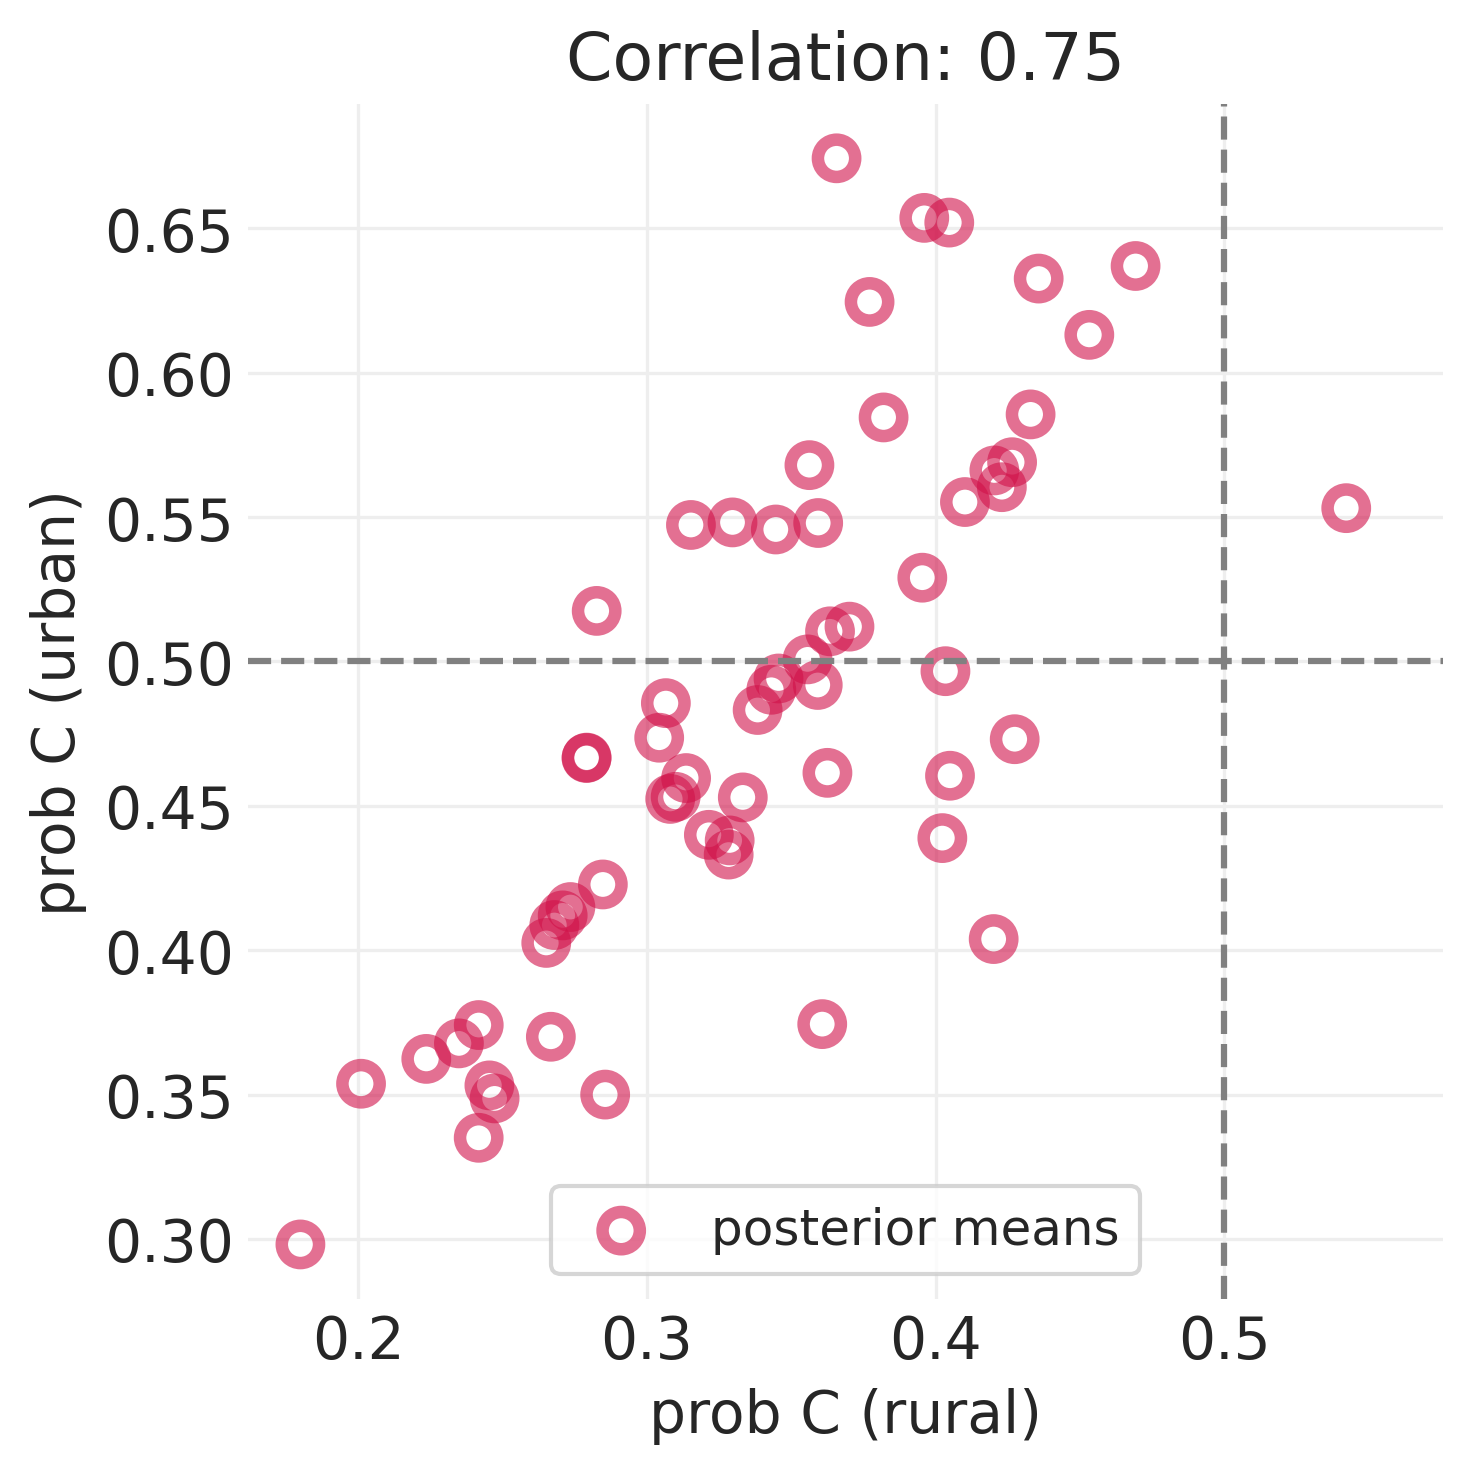

In [4]:
utils.display_image("fertility_p_C_rural_urban.png")

The plot shows that contraceptive use between urban/rural observations is correlated (cc>0.7)

### 🤔
- If we know about the contraceptive use in rural areas, you can make a better guess about urban contraceptive use because of this correlation
- **We are leaving information on the table by not letting the Golem--i.e. our statistical model--leverage this feature correlation**

This lecture focuses on building statistical models that can capture correlation information amongst features.
- makes inference more efficient by using partial pooling across features

> #### Estimating Correlation and Partial Pooling Demo

> McElreath goes on to show a demo of Bayesian updating in a model with a correlated features. Ιt's great, and I recommend going over the demo a few times, but I'm too lazy to implement it (nor clever enough to do so without an animation, which I'm trying to avoid). It'll go on the TODO list.

# Adding Correlated Features
- **One prior distribution for each _cluster/subgroup_**  $\rightarrow a_j \sim \text{Normal}(\bar a , \sigma)$; allows partial pooling
- If **one feature**, then **one-dimensional prior**
  - $a_j \sim \text{Normal}(\bar a, \sigma)$
- **N-dimensional distribution for N features**
  - rather than independent distributions (as we've been doing in previous lectures), we use joint distributions for features
  - $a_{j, 1..N} \sim \text{MVNormal}(A, \Sigma)$
  - e.g. $[\alpha_j, \beta_j] \sim \text{MVNormal}([\bar \alpha, \bar \beta], \Sigma_{\alpha, \beta})$
- **Hard part**: learning associations/correlations amongst features
  - "Estimating means is easy"
  - "Estimating standard deviations is hard"
  - "Estimating correlations is very hard"
  - That said, usually good idea to try to lear correlations:
    - if you don't have enough samples / signal, you'll fall back on the prior


### Previous model -- Using _uncorrelated_ urban features

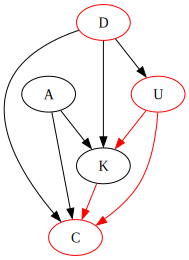

In [5]:
utils.draw_causal_graph(
    edge_list=[
        ("A", "C"),
        ("K", "C"),
        ("U", "C"),
        ("D", "C"),
        ("D", "U"),
        ("U", "K"),
        ("A", "K"),
        ("D", "K")
    ],
    node_props={
        "U": {"color": "red"},
        "D": {"color": "red"},
        "C": {"color": "red"}
    },
    edge_props={
        ("U", "K"): {"color": "red"},
        ("U", "C"): {"color": "red"},
        ("K", "C"): {"color": "red"}
    }
)


> This is the uncentered implementation, more-or-less copy-pasted from the previous Lecture

In [6]:
FERTILITY = utils.load_data("bangladesh")

USES_CONTRACEPTION = FERTILITY['use.contraception'].values.astype(int)
DISTRICT_ID, _ = pd.factorize(FERTILITY.district)
DISTRICT = np.arange(1, 62).astype(int)  # note: district 54 has no data so we create it's dim by hand
URBAN_ID, URBAN = pd.factorize(FERTILITY.urban, sort=True)

with pm.Model(coords={"district": DISTRICT}) as uncorrelated_model:
    
    # Mutable data
    urban = pm.MutableData("urban", URBAN_ID)
    
    # Priors -- priors for $\alpha$ and $\beta$ are separate, independent Normal distributions
    # District offset
    alpha_bar = pm.Normal("alpha_bar", 0, 1)  # the average district
    sigma = pm.Exponential('sigma', 1)  # variation amongst districts
    
    # Uncentered parameterization
    z_alpha = pm.Normal("z_alpha", 0, 1, dims='district')
    alpha = pm.Deterministic("alpha", alpha_bar + z_alpha * sigma, dims='district')
    
    # District / urban interaction
    beta_bar = pm.Normal("beta_bar", 0, 1)  # the average urban effect
    tau = pm.Exponential('tau', 1)  # variation amongst urban
    
    # Uncentered parameterization
    z_beta = pm.Normal("z_beta", 0, 1, dims='district')
    beta = pm.Deterministic("beta", beta_bar + z_beta * tau, dims='district')

    # Recored p(contraceptive)
    p_C = pm.Deterministic("p_C", pm.math.invlogit(alpha + beta))
    p_C_urban = pm.Deterministic("p_C_urban", pm.math.invlogit(alpha + beta))
    p_C_rural = pm.Deterministic("p_C_rural", pm.math.invlogit(alpha))
    
    # Likelihood
    p = pm.math.invlogit(alpha[DISTRICT_ID] + beta[DISTRICT_ID] * urban)
    C = pm.Bernoulli("C", p=p, observed=USES_CONTRACEPTION)
    
    uncorrelated_inference = pm.sample(target_accept=.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_bar, sigma, z_alpha, beta_bar, tau, z_beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


#### Demonstrate that feature priors are independent in uncorrelated model
Below we sample from the prior, and show that the $\alpha$ and $\beta$ parameters for all districts are aligned with the cardinal axes, indicating no correlation

In [7]:
def plot_2d_guassian_ci(R, mean=[0, 0], std=[1, 1], ci_prob=0.89, **plot_kwargs):
    """
    Plot the `ci_prob`% confidence interval for a 2D Gaussian defined
    by correlation matrix `R`, center `mean`, and standard deviations
    `std` along the marginals.
    """
    # Create a circle
    angles = np.linspace(0, 2 * np.pi, 100)
    radius = stats.norm.ppf(ci_prob)
    circle = radius * np.vstack([np.cos(angles), np.sin(angles)])
    
    # Warp circle using the covariance matrix
    D = np.diag(std)
    cov = D @ R @ D
    ellipse = sqrtm(np.matrix(cov)) @ circle
    plt.plot(
        ellipse[0] + mean[0], ellipse[1] + mean[1], linewidth=3, **plot_kwargs
    )

Sampling: [C, alpha_bar, beta_bar, sigma, tau, z_alpha, z_beta]


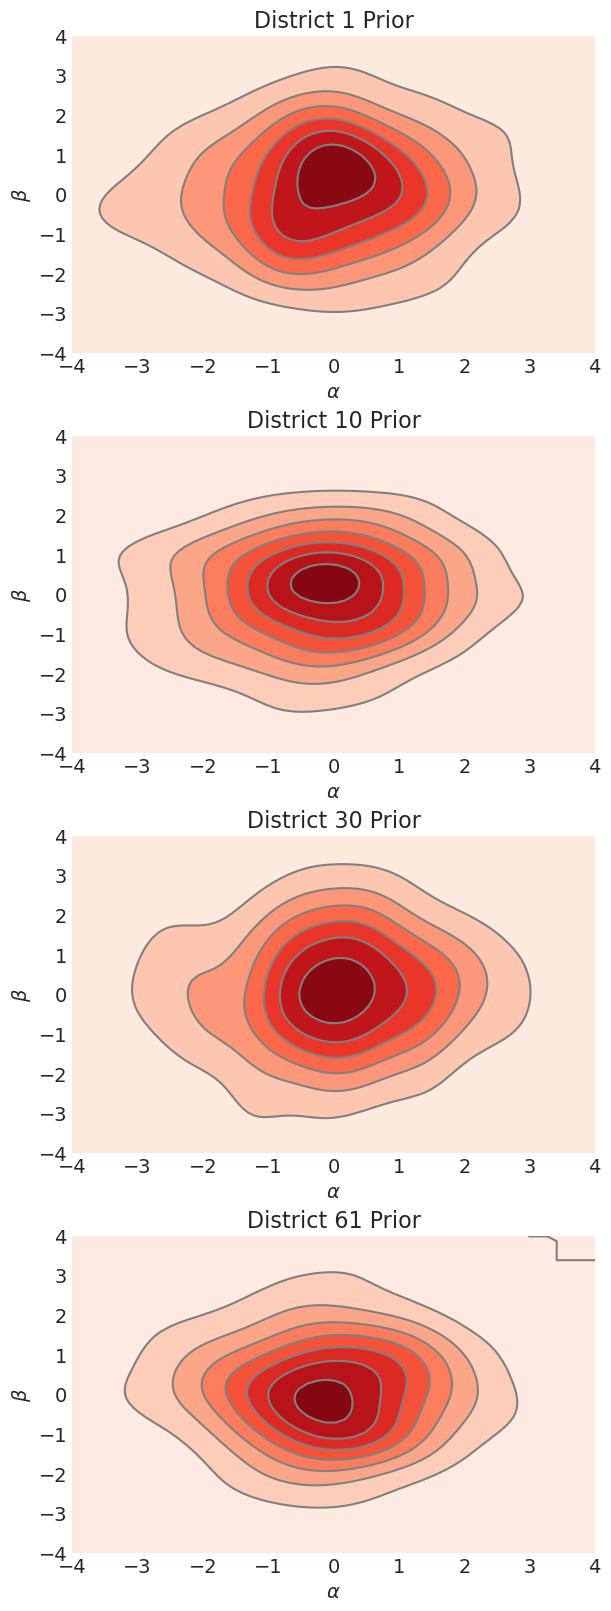

In [8]:
with uncorrelated_model:
    prior_pred = pm.sample_prior_predictive()

districts = [1, 10, 30, 61]
n_districts = len(districts)
fig, axs = plt.subplots(n_districts, 1, figsize=(6, n_districts * 4))
for ii, district in enumerate(districts):
    district_prior = prior_pred.prior.sel(district=district)
    plt.sca(axs[ii])
    az.plot_dist(district_prior['alpha'], district_prior['beta'], ax=axs[ii], contourf_kwargs={"cmap": "Reds"})
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])
    plt.xlabel("$\\alpha$")
    plt.ylabel("$\\beta$")
    plt.title(f"District {district} Prior")

Above we can see the priors for the uncorrelated model provide. We can tell they are uncorrelated because 
- the primary axes of the distribution lie orthogonally along the axes of parameter values.
- i.e. there's no "tilt" of th PDF countour

### Multivariate Normal Prior

$$
\begin{align*}
[\alpha_j, \beta_j] &= \text{MVNormal}([\bar \alpha, \bar \beta], R, [\sigma, \tau]) \\
[\alpha_j, \beta_j]&:= \text{features for district } j \\
R &:= \text{correlation matrix amongst features} \\
[\sigma, \tau] &:= \text{(independent) standard deviations for each parameter } j \\
\end{align*}
$$

#### Samples from multivariate prior

Standard deviations
[1. 2.]
Correlation Matrix
[[1.  0.8]
 [0.8 1. ]]
Covariance Matrix
[[1.  1.6]
 [1.6 4. ]]
Cholesky Matrix
[[1.  0. ]
 [1.6 1.2]]


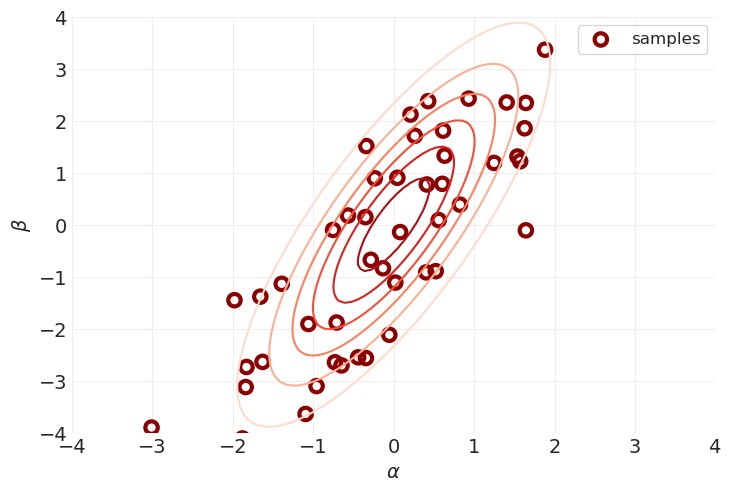

In [9]:
np.random.seed(123)
sigma = 1.0
tau = 2.0
R = np.array([[1, .8], [.8, 1]])  # correlation matrix


stds = np.array([sigma, tau])
D = np.diag(stds)
Sigma = D @ R @ D  # convert correlation matrix to covariance matrix
mvnorm = stats.multivariate_normal(cov=Sigma)

def mvn_norm_pdf(xs, ys, ):
    return mvnorm.pdf(np.vstack([xs, ys]).T)

RESOLUTION = 100
xs = ys = np.linspace(-4, 4, RESOLUTION)
utils.plot_2d_function(xs, ys, mvn_norm_pdf, cmap="Reds")

n_samples = 50
samples = mvnorm.rvs(n_samples)
utils.plot_scatter(samples[:, 0], samples[:, 1], color='darkred', alpha=1, label='samples')
plt.xlabel("$\\alpha$")
plt.ylabel("$\\beta$")
plt.xlim([-4, 4])
plt.ylim([-4, 4]);
plt.legend()

print(f"Standard deviations\n{stds}")
print(f"Correlation Matrix\n{R}")
print(f"Covariance Matrix\n{Sigma}")
print(f"Cholesky Matrix\n{np.linalg.cholesky(Sigma)}")

### Model with correlated urban features

$$
\begin{align*}
C_i &\sim \text{Bernouill}(p_i) \\
p_i &= \alpha_{D[i]} + \beta_{D[i]} U_i \\
[\alpha_j, \beta_j] &\sim \text{MVNormal}([\bar \alpha, \bar \beta], R, [\sigma, \tau]) \\
\sigma &\sim \text{Exponential}(1) \\
\tau &\sim \text{Exponential}(1) \\
R &\sim \text{LKJCorr}(4) 
\end{align*}
$$

#### On the `LKJCorr` prior

- Named after Lewandowski-Kurowicka-Joe, the authors of the original paper on the distribution
- **Prior for correlation matrices**
- Takes a shape parameter $\eta>0$
  - $\eta=1$ results in unifrom distribution over correlation matrices
  - $\eta \rightarrow \infty$, R approaches an identity matrix
- changes the distribution of correlation matrices

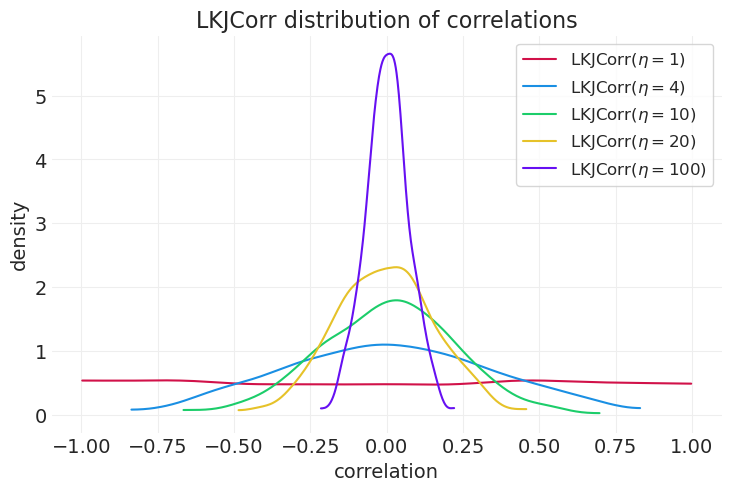

In [10]:
etas = [1, 4, 10, 20, 100]
for ii, eta in enumerate(etas):
    rv = pm.LKJCorr.dist(n=2, eta=eta)
    samples = pm.draw(rv, 1000)
    az.plot_dist(samples, color=f"C{ii}", label=f"LKJCorr$(\\eta={eta})$")
plt.legend()
plt.xlabel("correlation")
plt.ylabel("density")
plt.title("LKJCorr distribution of correlations");

####  Correlation Matrices Sampled from LKJCorr

In [11]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.linalg import sqrtm

def sample_correlation_matrix_LKJ(dim=2, eta=4, n_samples=1):
    
    # Samples; LKJCorr returns correlations are returned as
    # upper-triangular matrix entries
    rv = pm.LKJCorr.dist(n=dim, eta=eta)
    samples = pm.draw(rv, n_samples)
    
    # Convert upper triangular entries to full correlation matrices
    # (there's likely a way to vectorize this, but meh it's a demo)
    covs = []
    upper_idx = np.triu_indices(n=dim, k=1)
    for sample in samples:
        cov = np.eye(dim) * .5
        cov[upper_idx[0], upper_idx[1]] = sample
        cov += cov.T
        covs.append(cov)
    return np.array(covs)
    
    
def sample_LKJCorr_prior(eta=1, n_samples=20, ax=None):
    plt.sca(ax)
    for _ in range(n_samples):
        
        R = sample_correlation_matrix_LKJ(eta=eta)
        
        # Sample a random standard deviation along each dimension
        std = stats.expon(.1).rvs(2)  # exponential 
        # std = np.random.rand(2) * 10  # uniform
        # std = np.abs(np.random.randn(2))  # half-normal
        
        plot_2d_guassian_ci(R, std=std, color='C0', alpha=.25);
        
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.xlabel("$\\alpha$")
    plt.ylabel("$\\beta$")
    plt.title(f"Random Correlations Sampled\nfrom LKJCorr({eta}) prior");


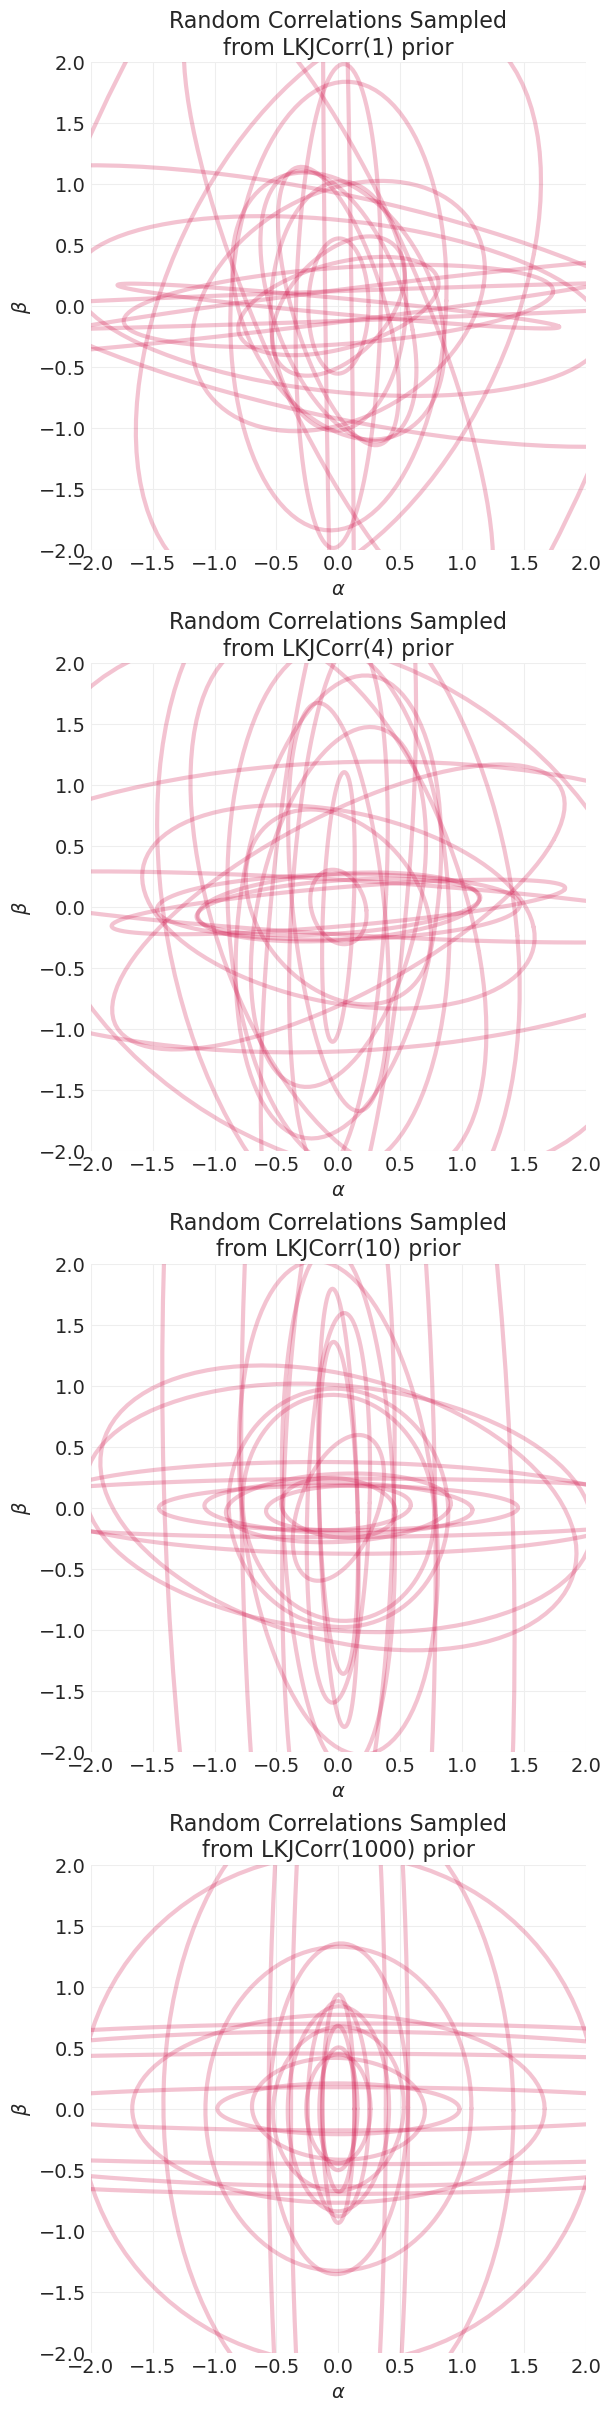

In [12]:
etas = [1, 4, 10, 1000]
n_etas = len(etas)
_, axs = plt.subplots(n_etas, 1, figsize=(6, 6 * n_etas))
for ii, eta in enumerate(etas):
    sample_LKJCorr_prior(eta=eta, ax=axs[ii])

we can see that as $\eta$ becomes larger, the axes of the correlation matrices become more alighed with the axes of the parameter space, providing diagonal covariance samples

### Model with correlated features
#### A couple of notes ⚠️
- We jump straight to the implementation with uncentered priors here, skipping the centered version. For details on the uncentered implementation, see the [PyMC docs](https://www.pymc.io/projects/docs/en/v3/pymc-examples/examples/case_studies/LKJ.html)
- We use `LKJCholeskyCov` instead `LKJCorr` for improved numerical stability and performance. For details, see https://discourse.pymc.io/t/uses-of-lkjcholeskycov-and-lkjcorr/3629/3
- We don't need to implement the `Chol_to_Corr` function in the lecture, as we can just pull the correlations directly out of the `LKJCholeskyCov` distribution

In [13]:
N_CORRELATED_FEATURES = 2
N_DISTRICTS = 61
ETA = 4

with pm.Model(coords={"district": DISTRICT}) as correlated_model:
    
    # Mutable data for posterior predictions
    urban = pm.MutableData("urban", URBAN_ID)
    
    # Priors
    # Feature correlation
    chol, corr, stds = pm.LKJCholeskyCov(
        "Rho",
        eta=ETA,
        n=N_CORRELATED_FEATURES,
        sd_dist=pm.Exponential.dist(1, size=N_CORRELATED_FEATURES)  # variation for params
    )
    
    # Uncentered parameterization for each variable
    z = pm.Normal("z", 0, 1, shape=(N_DISTRICTS, N_CORRELATED_FEATURES))
    v = pm.Deterministic("v", chol.dot(z.T).T)
    
    alpha_bar = pm.Normal("alpha_bar", 0, 1)  # the average district
    alpha = pm.Deterministic("alpha", alpha_bar + v[:, 0])
    
    beta_bar = pm.Normal("beta_bar", 0, 1)  # the average urban effect
    beta = pm.Deterministic("beta", beta_bar + v[:, 1])

    # Record values for reporting
    pm.Deterministic("feature_cov", chol.dot(chol.T))
    pm.Deterministic("feature_corr", corr)
    pm.Deterministic("feature_std", stds)
    pm.Deterministic("p_C", pm.math.invlogit(alpha + beta), dims='district')
    pm.Deterministic("p_C_urban", pm.math.invlogit(alpha + beta), dims='district')
    pm.Deterministic("p_C_rural", pm.math.invlogit(alpha), dims='district')
    
    # Likelihood
    p = pm.math.invlogit(alpha[DISTRICT_ID] + beta[DISTRICT_ID] * urban)
    C = pm.Bernoulli("C", p=p, observed=USES_CONTRACEPTION)
    
    correlated_inference = pm.sample(target_accept=.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Rho, z, alpha_bar, beta_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


### Analyzing feature correlation

In [14]:
correlated_posterior_mean = correlated_inference.posterior.mean(dim=('chain', 'draw'))
print(f'Feature Covariance\n', correlated_posterior_mean['feature_cov'].values)
print(f'Feature Correlation\n', correlated_posterior_mean['feature_corr'].values)
print(f'Feature Std\n', correlated_posterior_mean['feature_std'].values)

Feature Covariance
 [[ 0.3116134  -0.2386851 ]
 [-0.2386851   0.59110864]]
Feature Correlation
 [[ 1.         -0.55056752]
 [-0.55056752  1.        ]]
Feature Std
 [0.54980519 0.74136565]


### Compare to prior

In [15]:
with correlated_model:
    # Add prior samples
    correlated_prior_predictive = pm.sample_prior_predictive()

Sampling: [C, Rho, alpha_bar, beta_bar, z]


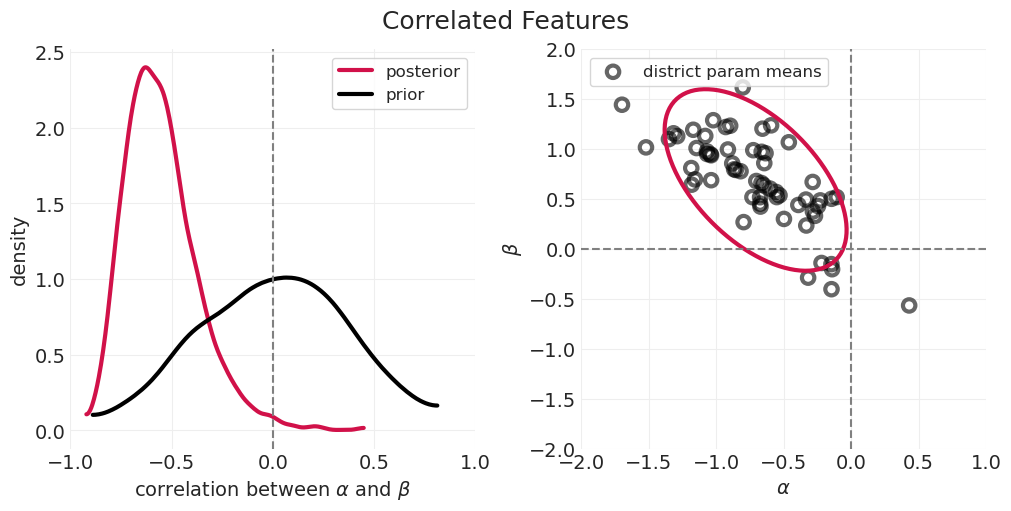

In [16]:
def plot_posterior_mean_alpha_beta(posterior_mean, title=None):
    alphas = posterior_mean['alpha'].values
    betas =  posterior_mean['beta'].values
    alpha_mean = posterior_mean['alpha'].mean().values
    beta_mean = posterior_mean['beta'].mean().values

    # Correlated feature params
    if "feature_corr" in posterior_mean:
        posterior_R = posterior_mean['feature_corr'].values
        posterior_std = posterior_mean['feature_std'].values

    # Independent feature params
    else:
        cc = np.corrcoef(alphas, betas)[0][1]
        posterior_R = np.array([[1, cc], [cc, 1]])
        posterior_std = np.array([posterior_mean['sigma'], posterior_mean['tau']])

    plot_2d_guassian_ci(
        R=posterior_R,
        mean=(alpha_mean, beta_mean),
        std=posterior_std,
        color='C0'
    )

    utils.plot_scatter(
        xs=posterior_mean['alpha'],
        ys=posterior_mean['beta'],
        color='k', label='district param means'
    )

    plt.axvline(0, color='gray', linestyle='--')
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlim([-2, 1])
    plt.ylim([-2, 2])
    plt.xlabel("$\\alpha$")
    plt.ylabel("$\\beta$")
    plt.legend();
    plt.title(title)

_, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot correlation distribution for posterior and prior
plt.sca(axs[0])
plot_kwargs = {"linewidth": 3}
az.plot_dist(
    correlated_inference.posterior['feature_corr'][:, :, 0, 1],
    label='posterior', plot_kwargs=plot_kwargs,
    ax=axs[0]
)
az.plot_dist(
    correlated_prior_predictive.prior['feature_corr'][:, :, 0, 1],
    color='k',
    label='prior', plot_kwargs=plot_kwargs,
    ax=axs[0]
)

plt.axvline(0, color='gray', linestyle='--')
plt.xlim([-1, 1])
plt.xlabel("correlation between $\\alpha$ and $\\beta$")
plt.ylabel("density")
plt.legend();

plt.sca(axs[1])
    
plot_posterior_mean_alpha_beta(correlated_posterior_mean)
plt.suptitle("Correlated Features", fontsize=18);

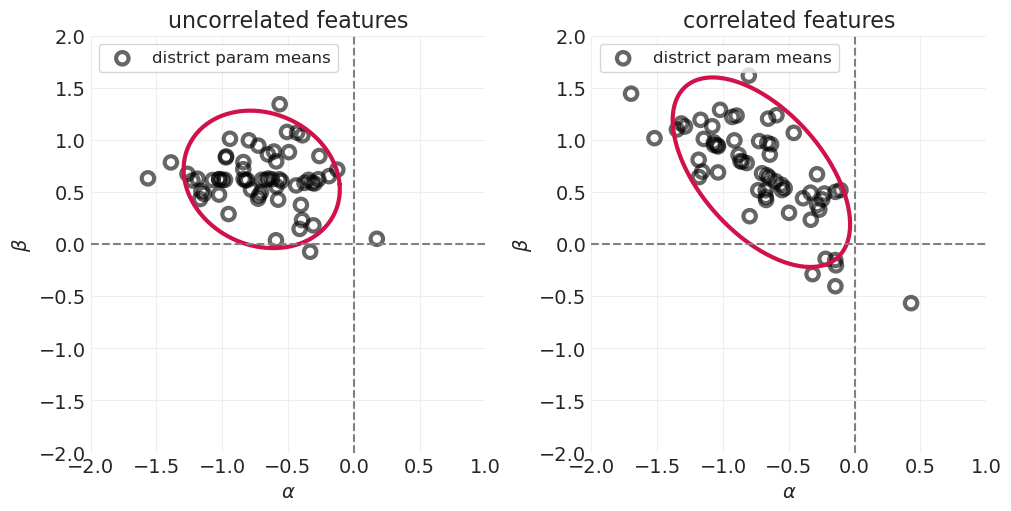

In [17]:
uncorrelated_posterior_mean = uncorrelated_inference.posterior.mean(dim=('chain', 'draw'))

_, axs = plt.subplots(1, 2, figsize=(10, 5))

plt.sca(axs[0])
plot_posterior_mean_alpha_beta(uncorrelated_posterior_mean, title='uncorrelated features')

plt.sca(axs[1])
plot_posterior_mean_alpha_beta(correlated_posterior_mean, title='correlated features')

Comparing to the model that does not model feature correlations: the model with uncorrelated features exhibits a much weaker negative correlation (i.e. the red ellipse on the left is less "tilted" downward.

#### Comparing models on the outcome scale.

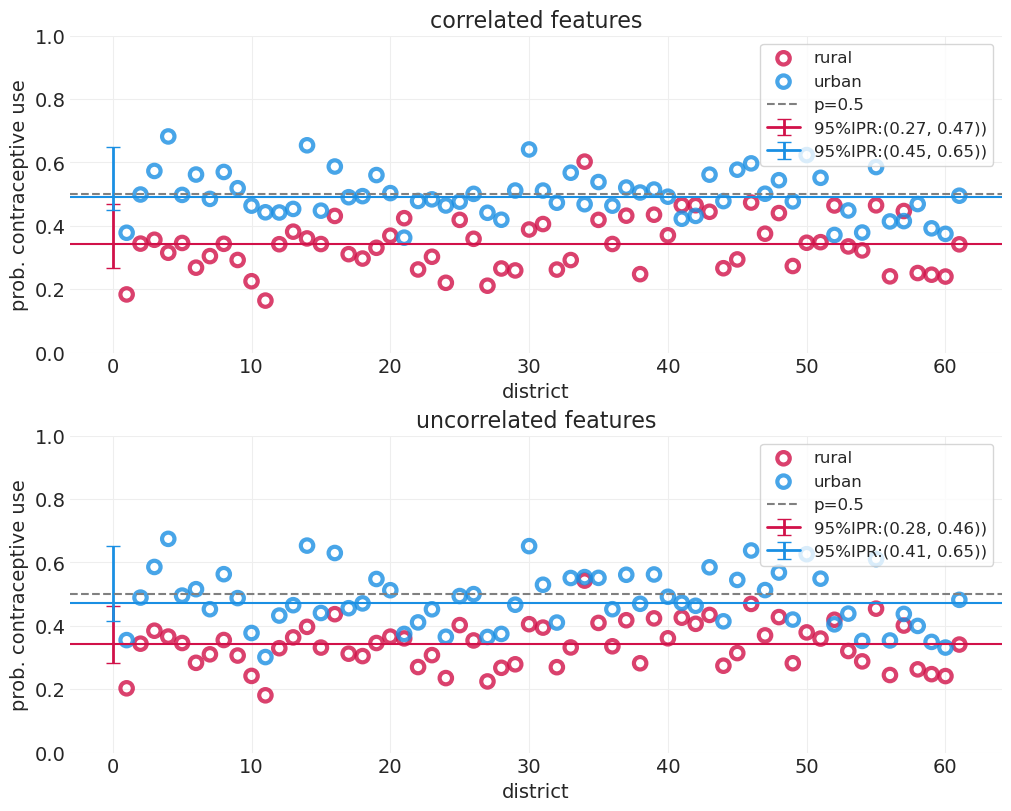

In [18]:
def plot_p_C_district_rural_urban(posterior_mean, title=None):
    for ii, (label, p_C) in enumerate(zip(['rural', 'urban'], ['p_C_rural', 'p_C_urban'])):    
        color = f"C{ii}"
        plot_data = posterior_mean[p_C]
        utils.plot_scatter(DISTRICT, plot_data, label=label, color=color, alpha=.8)
        
        # Add quantile indicators
        ql, median, qu = np.quantile(plot_data, [.25, .5, .975])
        error = np.array((median-ql, qu-median))[:, None]
        plt.errorbar(
            x=0,
            y=median,
            yerr=error, 
            color=color,
            capsize=5,
            linewidth=2,
            label=f'95%IPR:({ql:0.2f}, {qu:0.2f}))'
        )
        plt.axhline(median, color=color)
        
        
    plt.axhline(.5, color='gray', linestyle='--', label='p=0.5')
    plt.legend(loc='upper right')
    plt.ylim([0, 1])
    plt.xlabel("district")
    plt.ylabel("prob. contraceptive use")
    plt.title(title)
    
_, axs = plt.subplots(2, 1, figsize=(10, 8))

plt.sca(axs[0])
plot_p_C_district_rural_urban(correlated_posterior_mean, title='correlated features')

plt.sca(axs[1])
plot_p_C_district_rural_urban(uncorrelated_posterior_mean, title='uncorrelated features')


- Modeling feature correlation allows urban areas to capture urban variance differently. Though the effect is subtle, the correlated feature model (top) exhibits smaller Inner-percentile range (IPR) (0.45-0.65) than the uncorrelated feature model (0.41-0.65). 
- ⚠️ This is actually the opposite of what was reported in the lecture. My intuition would be that there would be less posterior variability because we're sharing information across features, and thus reducing our uncertainty. But I could easily be doing or interpreting something incorrectly here.

### Looking at outcome space

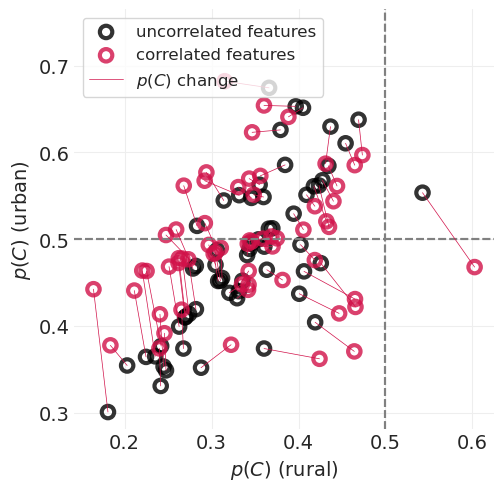

In [19]:
def plot_pC_rural_urban_xy(posterior_mean, label, color):
    utils.plot_scatter(
        xs=posterior_mean['p_C_rural'],
        ys=posterior_mean['p_C_urban'],
        label=label,
        color=color, alpha=.8
    )
        
    plt.axhline(.5, color='gray', linestyle='--')
    plt.axvline(.5, color='gray', linestyle='--')
    plt.xlabel("$p(C)$ (rural)")
    plt.ylabel("$p(C)$ (urban)")
    plt.legend()
    plt.axis('square')

def plot_pC_xy_movement(posterior_mean_a, posterior_mean_b):
    xs_a = posterior_mean_a['p_C_rural']
    xs_b = posterior_mean_b['p_C_rural']
    ys_a = posterior_mean_a['p_C_urban']
    ys_b = posterior_mean_b['p_C_urban']

    for ii, (xa, xb, ya, yb) in enumerate(zip(xs_a, xs_b, ys_a, ys_b)):
        label = '$p(C) $ change' if not ii else None
        plt.plot((xa, xb), (ya, yb), linewidth=.5, color='C0', label=label)
    plt.legend(loc="upper left")


plot_pC_rural_urban_xy(uncorrelated_posterior_mean, label='uncorrelated features', color='k')
plot_pC_rural_urban_xy(correlated_posterior_mean, label='correlated features', color='C0')
plot_pC_xy_movement(uncorrelated_posterior_mean, correlated_posterior_mean)

#### Including feature correlations

- Points move because the transfer of information across features provides better estimates of $p(C)$
- There's a negative correlation between rural areas and the **difference** between urban contraceptive use in urban areas
  - When a district's rural areas have high contraceptive use, the difference will be smaller (i.e. urban areas will also have high contraceptive use)
  - When rural contraceptive use is low, urban areas will be more different (i.e. urban areas will still tend to have higher contraceptive use)

# Review: Correlated Varying Effects
Priors that **learn correlation** amongst features. Provides the following benefits
1. partial pooling across features -- memory, shared information improves efficiency
2. learns correlations -- this is the _focus_ of research questions

💡 Varying effects can be correlated _and can still be learned_ without priors that incorporate correlation structure. However, incorporating correlations explicitly allows partial pooling, and is thus more efficient and provides more explicit information about those correlations.


# BONUS: Non-centered (aka Transformed) Priors
## Inconvenient Posteriors
- Inefficient MCMC caused by steep curvature in the neg-log-likelihood
- Hamiltonian Monte Carlo has trouble exploring steep surface
  - leading to "divergent" transistions
  - "punching through wall of skate park"
  - detected when the Hamiltonian changes value dramatically between start/end of proposal
- Transforming the prior to be a "smoother skate park" helps

## Example: Devil's Funnel prior

$$
\begin{align*}
v &\sim \text{Normal}(0, \sigma_v) \\
x &\sim \text{Normal}(0, \exp({v}))
\end{align*}
$$

As $\sigma_v$ increases, a nasty trough forms in the prior probability surface that is difficult for Hamiltonian dynamics to sample--i.e. the skatepark is too steep and narrow.

I'm too lazy to code up the fancy HMC animation that McElreath uses to visualize each divergent path. However, we can still verifty that the number of divergences increases when sampling the devil's funnel as we increase the v prior's $\sigma$ in the devil's funnel prior.

### Centered-prior models

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v, x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v, x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 131 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v, x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 566 divergences after tuning. Increase `target_accept` or reparameterize.


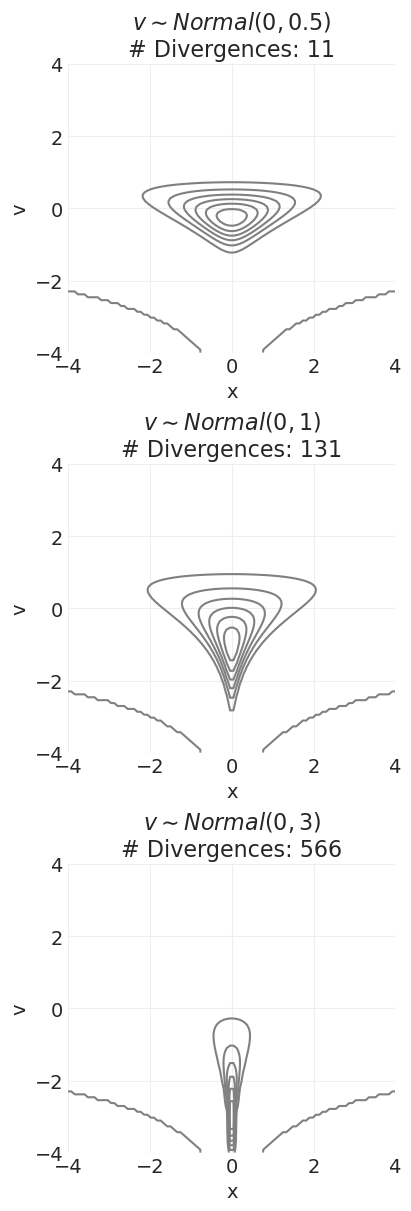

In [20]:
from functools import partial
xs = vs = np.linspace(-4, 4, 100)

def prior_devils_funnel(xs, vs, sigma_v=.5):
    
    log_prior_v = stats.norm(0, sigma_v).logpdf(vs)
    log_prior_x = stats.norm(0, np.exp(vs)).logpdf(xs)
    
    log_prior = log_prior_v + log_prior_x
    return np.exp(log_prior - log_prior.max())


# Loop over sigma_v, and show that divergences increase
# as the depth and narrowness of the trough increases
# for low values of v
sigma_vs = [.5, 1, 3]
n_sigma_vs = len(sigma_vs)
fig, axs = plt.subplots(3, 1, figsize=(4, 4 * n_sigma_vs))

for ii, sigma_v in enumerate(sigma_vs):
    with pm.Model() as centered_devils_funnel:
        v = pm.Normal('v', 0, sigma_v)
        x = pm.Normal('x', 0, pm.math.exp(v))
        centered_devils_funnel_inference = pm.sample()
        n_divergences = centered_devils_funnel_inference.sample_stats.diverging.sum().values
    
    prior = partial(prior_devils_funnel, sigma_v=sigma_v)
    plt.sca(axs[ii])
    utils.plot_2d_function(xs, ys, prior, colors="gray", ax=axs[ii])
    plt.xlabel("x")
    plt.ylabel("v")
    plt.title(f"$v \sim Normal(0, {sigma_v})$\n# Divergences: {n_divergences}")

## What to do?
- Smaller step size: handles steepness better, but takes longer to explore the posterior
- Re-parameterize (tranform) to make surface smoother

## Non-centered prior
We add an auxilary variable $z$ that has a smooth probability surface. We then sample that auxilary variable, and transform it to obtain the target variable distribution. For the case of the devi's funnel prior:

$$
\begin{align*}
v &\sim \text{Normal}(0, \sigma_v) \\
z &\sim \text{Normal}(0, 1) \\
x &= z \exp(v)
\end{align*}
$$

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v, z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v, z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v, z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


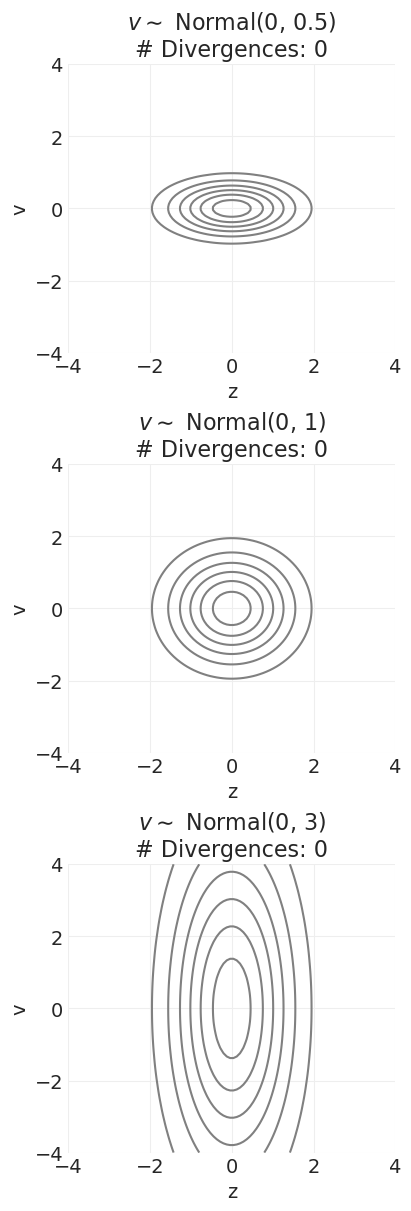

In [21]:
sigma_vs = [.5, 1, 3]
n_sigma_vs = len(sigma_vs)
fig, axs = plt.subplots(3, 1, figsize=(4, 4 * n_sigma_vs))

def prior_noncentered_devils_funnel(xs, vs, sigma_v=.5):
    """Reparamterize into a smoother auxilary variable space"""
    log_prior_v = stats.norm(0, sigma_v).logpdf(vs)
    log_prior_z = stats.norm(0, 1).logpdf(xs)
    log_prior = log_prior_v + log_prior_z
    return np.exp(log_prior - log_prior.max())

for ii, sigma_v in enumerate(sigma_vs):
    with pm.Model() as noncentered_devils_funnel:
        v = pm.Normal('v', 0, sigma_v)
        z = pm.Normal('z', 0, 1)
        # Record x for reporting
        x = pm.Deterministic('x', z * pm.math.exp(v))
        noncentered_devils_funnel_inference = pm.sample()
        n_divergences = noncentered_devils_funnel_inference.sample_stats.diverging.sum().values
        
    prior = partial(prior_noncentered_devils_funnel, sigma_v=sigma_v)
    plt.sca(axs[ii])
    utils.plot_2d_function(xs, ys, prior, colors="gray", ax=axs[ii])
    plt.xlabel("z")
    plt.ylabel("v")
    plt.title(f"$v \sim$ Normal(0, {sigma_v})\n# Divergences: {n_divergences}")

- By reparameterizing, we get to sample multi-dimensional Normal distributions, which are smoother parabolas in the log space.

- We can see that the number of divergence is consistently reduced for all values of prior variance.

#### Check HMC Diagnostics

In [22]:
az.summary(noncentered_devils_funnel_inference)['r_hat']

v    1.0
z    1.0
x    1.0
Name: r_hat, dtype: float64

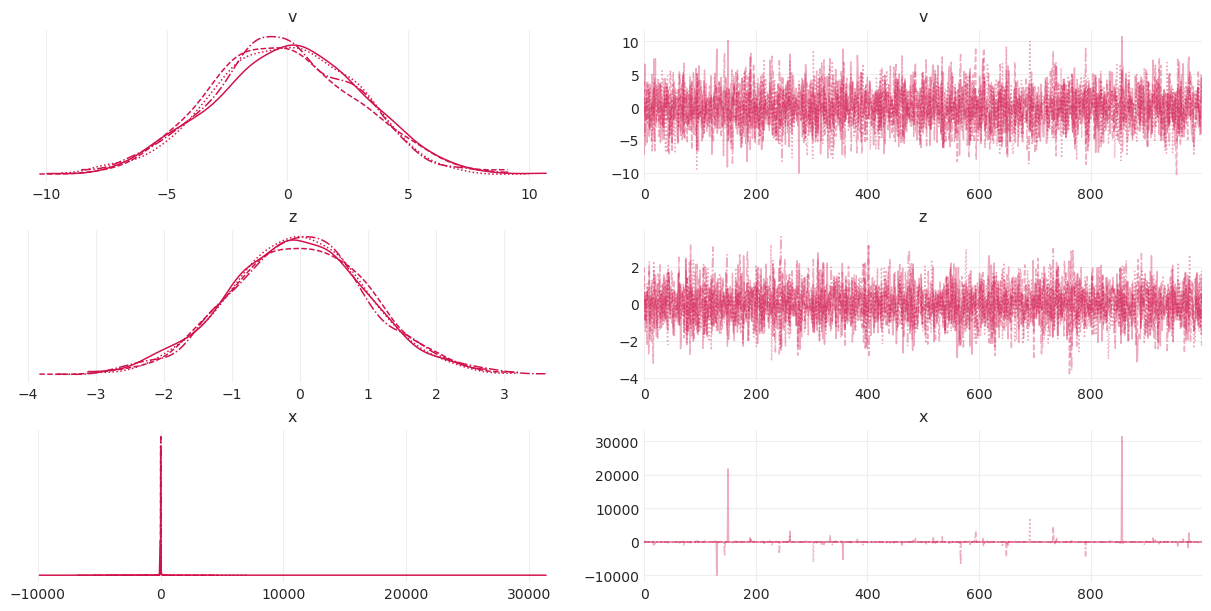

In [23]:
az.plot_trace(noncentered_devils_funnel_inference);

Diagnostics look good 👍
- `Rhat`s = 1
- $v$ and $z$ chains exhibit "fuzzy caterpillar" behavior

## Cholesky Factors & Correlation Matrices
- Cholesky factor, $\bf L$ provides an efficient means for encoding a correlation matrix $\Omega$ (requires fewer floating point numbers than the full correlation matrix)
- $\Omega = \bf LL^T$
- $\bf L$ is a lower-triangular matrix
- we can sample data with correlation $\Omega$, and standard deviations $\sigma_i$, using the Cholesky factorization $\bf L$ of $\Omega$ as follows: 

$$
X_\Omega \sim \text{diag}(\sigma_i)\bf{LZ},
$$ 
where $\bf Z$ is a matrix of z-scores sampled from a standard normal distribution

#### Demonstrate reconstructing correlation matrix from Cholesky factor

In [24]:
orig_corr = np.array([[1, .6], [.6, 1]])
print("Ground-truth Correlation Matrix\n", orig_corr)

L = np.linalg.cholesky(orig_corr)
print("\nCholesky Matrix of correlation matrix, L\n", L)
print("\nReconstructed correlation matrix from L\n", L @ L.T)

Ground-truth Correlation Matrix
 [[1.  0.6]
 [0.6 1. ]]

Cholesky Matrix of correlation matrix, L
 [[1.  0. ]
 [0.6 0.8]]

Reconstructed correlation matrix from L
 [[1.  0.6]
 [0.6 1. ]]


#### Demonstrate sampling random corrleation matrix from z-scores and the Cholesky factor

In [25]:
np.random.seed(12345)
N = 100_000
orig_sigmas = [2, .5]

# Matrix of z-score samples
Z = stats.norm().rvs(size=(2, N))
print("Raw z-score samples are indpendent\n", np.corrcoef(Z[0], Z[1]))

# Transform Z-scores using the Cholesky factorization of the correlation matrix
sLZ = np.diag(orig_sigmas) @ L @ Z

corr_sLZ = np.corrcoef(sLZ[0], sLZ[1])
print("\nCholesky-transformed z-scores have original correlation encoded\n", corr_sLZ)
assert np.isclose(orig_corr[0, 1], corr_sLZ[0, 1], atol=.01)

std_sLZ = sLZ.std(axis=1)
print("\nOriginal std devs also encoded in transformed z-scores:\n", std_sLZ)
assert np.isclose(orig_sigmas[0], std_sLZ[0], atol=.01)
assert np.isclose(orig_sigmas[1], std_sLZ[1], atol=.01)

Raw z-score samples are indpendent
 [[1.         0.00293945]
 [0.00293945 1.        ]]

Cholesky-transformed z-scores have original correlation encoded
 [[1.         0.60268456]
 [0.60268456 1.        ]]

Original std devs also encoded in transformed z-scores:
 [2.00212936 0.50024976]


## When to use Transformed Priors
- depends on context
- Centered:
  - Lot's of data in each cluster/subgroup
  - likelihood-dominant scenario
- Non-centered:
  - Many clusters/subgroups, with sparse data in some of the clusters
  - prior-dominant scenario